In [6]:
## Sequence Data
scales = ['C4', 'C4', 'G4', 'G4', 'A4', 'A4', 'G4', 'F4', 'F4', 'E4', 'E4', 'D4', 'D4', 'C4',
          'G4', 'G4', 'F4', 'F4', 'E4', 'E4', 'D4', 'G4', 'G4', 'F4', 'F4', 'E4', 'E4', 'D4',
          'C4', 'C4', 'G4', 'G4', 'A4', 'A4', 'G4', 'F4', 'F4', 'E4', 'E4', 'D4', 'D4', 'C4']
durations = [4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 8,
             4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 8,
             4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 8]

In [24]:
## Make an audio file to play
!pip install pretty_midi
import pretty_midi as pm
import numpy as np
from IPython.display import Audio

midi_data = pm.PrettyMIDI()

#piano
piano_program = pm.instrument_name_to_program('Acoustic Grand Piano')
piano = pm.Instrument(program=piano_program)

currentTime = 0
seconds4Quarter = 0.5/4.

for scale, duration in zip(scales, durations):
  note_duration = seconds4Quarter * duration
  note = pm.Note(velocity=100, pitch=pm.note_name_to_number(scale), start=currentTime, end=currentTime + note_duration)
  currentTime += note_duration
  piano.notes.append(note)
midi_data.instruments.append(piano)
audio_data = midi_data.synthesize()
Audio(audio_data, rate=44100)


In [25]:
## Download the generated midi audio file
import soundfile as sf
sf.write('output_audio.wav', audio_data, 44100)

In [9]:
## Data prepration
note_numbers = []
for scale in scales:
  note_numbers.append(pm.note_name_to_number(scale))

notes = list(zip(note_numbers, durations))
print(notes)

[(60, 4), (60, 4), (67, 4), (67, 4), (69, 4), (69, 4), (67, 8), (65, 4), (65, 4), (64, 4), (64, 4), (62, 4), (62, 4), (60, 8), (67, 4), (67, 4), (65, 4), (65, 4), (64, 4), (64, 4), (62, 8), (67, 4), (67, 4), (65, 4), (65, 4), (64, 4), (64, 4), (62, 8), (60, 4), (60, 4), (67, 4), (67, 4), (69, 4), (69, 4), (67, 8), (65, 4), (65, 4), (64, 4), (64, 4), (62, 4), (62, 4), (60, 8)]


In [11]:
import numpy as np

def one_hot_encode_notes(notes):
  num_scales = 13
  num_durations = 2
  total_features = num_scales + num_durations

  one_hot_encoded = np.zeros((len(notes), total_features), dtype=int)

  for i, (scale_num, duration) in enumerate(notes):
    scale_index = scale_num - 60
    duration_index = 13 if duration == 4 else 14

    one_hot_encoded[i, scale_index] = 1
    one_hot_encoded[i, duration_index] = 1
  return one_hot_encoded

encoded_notes = one_hot_encode_notes(notes)

In [12]:
def prepare_sequence(encoded_notes, sequence_length=4):
  X = []
  y = []
  for i in range(len(encoded_notes) - sequence_length):
    sequence_in = encoded_notes[i:i + sequence_length]
    sequence_out = encoded_notes[i + sequence_length]
    X.append(sequence_in)
    y.append(sequence_out)
  return np.array(X), np.array(y)

sequence_length = 4
X, y = prepare_sequence(encoded_notes, sequence_length)

In [17]:
## Model Design: RNN
from keras.layers import Input, LSTM, Dense
from keras.models import Model

sequence_length = 4
num_features = 15
num_scale_units = 13
num_duration_units = 2

inputs = Input(shape=(sequence_length, num_features))
lstm_out = LSTM(64, return_sequences=False)(inputs)
scale_output = Dense(num_scale_units, activation='softmax', name='scale_output')(lstm_out)
duration_output = Dense(num_duration_units, activation='softmax', name='duration_output')(lstm_out)

model = Model(inputs=inputs, outputs=[scale_output, duration_output])

model.compile(optimizer='Adam',
              loss={'scale_output':'categorical_crossentropy', 'duration_output':'categorical_crossentropy'},
              metrics={'scale_output':'accuracy', 'duration_output':'accuracy'})

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 4, 15)]              0         []                            
                                                                                                  
 lstm_1 (LSTM)               (None, 64)                   20480     ['input_3[0][0]']             
                                                                                                  
 scale_output (Dense)        (None, 13)                   845       ['lstm_1[0][0]']              
                                                                                                  
 duration_output (Dense)     (None, 2)                    130       ['lstm_1[0][0]']              
                                                                                            

In [18]:
## Model training
hist = model.fit(X, [y[:, 0:num_scale_units], y[:, num_scale_units:num_features]],
                 epochs=200, verbose=0, validation_split=0.2)

Epoch 1/200
1/1 - 4s - loss: 3.3002 - scale_output_loss: 2.5688 - duration_output_loss: 0.7315 - scale_output_accuracy: 0.0000e+00 - duration_output_accuracy: 0.1333 - val_loss: 3.2426 - val_scale_output_loss: 2.5344 - val_duration_output_loss: 0.7081 - val_scale_output_accuracy: 0.0000e+00 - val_duration_output_accuracy: 0.2500 - 4s/epoch - 4s/step
Epoch 2/200
1/1 - 0s - loss: 3.2736 - scale_output_loss: 2.5592 - duration_output_loss: 0.7144 - scale_output_accuracy: 0.0000e+00 - duration_output_accuracy: 0.1333 - val_loss: 3.2245 - val_scale_output_loss: 2.5265 - val_duration_output_loss: 0.6981 - val_scale_output_accuracy: 0.0000e+00 - val_duration_output_accuracy: 0.3750 - 79ms/epoch - 79ms/step
Epoch 3/200
1/1 - 0s - loss: 3.2474 - scale_output_loss: 2.5496 - duration_output_loss: 0.6978 - scale_output_accuracy: 0.0000e+00 - duration_output_accuracy: 0.3667 - val_loss: 3.2069 - val_scale_output_loss: 2.5184 - val_duration_output_loss: 0.6885 - val_scale_output_accuracy: 0.1250 - va

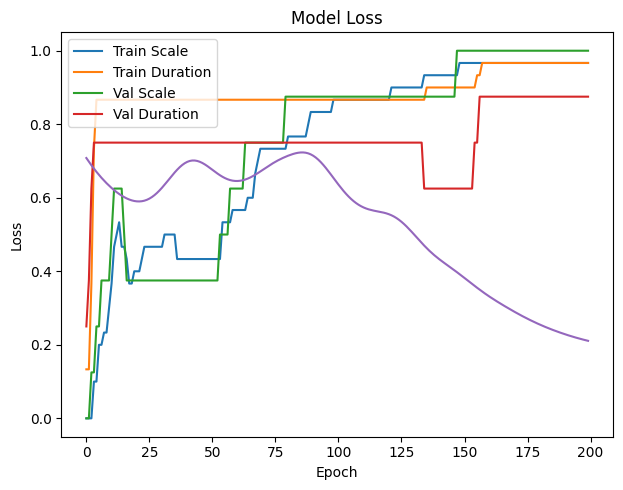

In [19]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['scale_output_accuracy'])
plt.plot(hist.history['duration_output_accuracy'])
plt.plot(hist.history['val_scale_output_accuracy'])
plt.plot(hist.history['val_duration_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Scale', 'Train Duration', 'Val Scale', 'Val Duration'], loc='upper left')
# Plot training & validation loss valuesplt.subplot(1, 2, 2)plt.plot(hist.history['scale_output_loss'])plt.plot(hist.history['duration_output_loss'])plt.plot(hist.history['val_scale_output_loss'])
plt.plot(hist.history['val_duration_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Scale', 'Train Duration', 'Val Scale', 'Val Duration'], loc='upper left')
plt.tight_layout()
plt.show()

In [21]:
## Model prediction test
### with only first four notes

prediction_length = y.shape[0]

given_notes = X[0:1]
input_sequence = given_notes
predicted_notes = []
for note in given_notes[0]:
  scale = np.argmax(note[0:num_scale_units], axis=-1) + 60
  duration = 4 if np.argmax(note[num_scale_units:num_features], axis=-1) == 0 else 8

for i in range(prediction_length):
  scale_pred, duration_pred = model.predict(input_sequence)
  next_scale = np.argmax(scale_pred, axis=-1)
  next_duration = 4 if np.argmax(duration_pred, axis=-1) == 0 else 8
  predicted_notes.append((next_scale.item() + 60, next_duration))

  next_note_encoded = np.zeros((1, 1, given_notes.shape[2]))
  next_note_encoded[0, 0, next_scale] = 1
  next_note_encoded[0, 0, -2 if next_duration == 4 else -1] = 1

  input_sequence = np.concatenate((input_sequence[:, 1:, :], next_note_encoded), axis=1)

print(predicted_notes)

1/1 [==============================] - 0s 42ms/step


In [23]:
def midi(predicted_notes):
  midi_data = pm.PrettyMIDI()

  piano_program = pm.instrument_name_to_program('Acoustic Grand Piano')
  piano = pm.Instrument(program=piano_program)

  currentTime = 0
  seconds4Quarter = 0.5/4.
  for scale, duration in predicted_notes:
    note_duration = seconds4Quarter * duration
    note = pm.Note(velocity=100, pitch=scale, start=currentTime, end=currentTime + note_duration)
    currentTime += note_duration
    piano.notes.append(note)
  midi_data.instruments.append(piano)
  audio_data = midi_data.synthesize()
  Audio(audio_data, rate=44100)
  sf.write('output_audio.wav', audio_data, 44100)

midi(predicted_notes)